In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Install necessary libraries
# !pip install wordcloud
!pip install emoji
# !pip install nltk
# !pip install scikit-learn
# !pip install matplotlib seaborn

# Import all required libraries
import pandas as pd
import numpy as np
import nltk
import re
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download required NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [4]:
import pandas as pd

# Example (adjust path based on your structure)
true_path = "/content/drive/MyDrive/ISOT_Dataset/True.csv"
fake_path = "/content/drive/MyDrive/ISOT_Dataset/Fake.csv"
true = pd.read_csv(true_path)
fake = pd.read_csv(fake_path)


print("Dataset loaded! ✅")
# print(true_df.head())


# Add labels
fake['label'] = 0  # 0 = Fake news
true['label'] = 1  # 1 = Real news

# Combine the datasets
data = pd.concat([fake, true], ignore_index=True)

# Shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# Check dataset
data.head()

Dataset loaded! ✅


,title,text,subject,date,label
0,"Rebel Honduran police ignore curfew order, ele...",TEGUCIGALPA (Reuters) - Hondurans spilled into...,worldnews,"December 3, 2017",1
1,President Obama Responds To Little Girl On Fa...,"Recently, a video post went viral on Facebook ...",News,"February 20, 2016",0
2,"Trump misunderstood MIT climate research, univ...",NEW YORK (Reuters) - Massachusetts Institute ...,politicsNews,"June 1, 2017",1
3,OUTSTANDING! WATCH Lee Greenwood Sing ‘God Ble...,,politics,"Jan 19, 2017",0
4,GLOSSED OVER: Key Questions Emerge After Death...,21st Century Wire asks What really happened in...,US_News,"February 17, 2016",0


In [5]:
import nltk
nltk.download('punkt_tab')
# Define the text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    return text

# Define the stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess text
def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data['text'].apply(preprocess)

# Check result
data[['text', 'processed_text', 'label']].head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,processed_text,label
0,TEGUCIGALPA (Reuters) - Hondurans spilled into...,tegucigalpa reuter honduran spill street capit...,1
1,"Recently, a video post went viral on Facebook ...",recent video post went viral facebook littl gi...,0
2,NEW YORK (Reuters) - Massachusetts Institute ...,new york reuter massachusett institut technolo...,1
3,,,0
4,21st Century Wire asks What really happened in...,st centuri wire ask realli happen death suprem...,0


In [6]:
import spacy
from textblob import TextBlob

# Load spaCy English model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:

# Corrected feature extraction function
def extract_correct_features(text):
    doc = nlp(text)

    features = {}

    # Basic features
    features['word_count'] = len(text.split())
    features['char_count'] = len(text)
    features['sentence_count'] = len(sent_tokenize(text))
    features['avg_word_length'] = np.mean([len(word) for word in text.split()]) if len(text.split()) > 0 else 0
    features['avg_sentence_length'] = len(text.split())/len(sent_tokenize(text)) if len(sent_tokenize(text)) > 0 else 0

    # NER features
    entity_labels = ['person', 'norp', 'fac', 'org', 'gpe', 'loc', 'product',
                     'event', 'work_of_art', 'law', 'language', 'date', 'time',
                     'percent', 'money', 'quantity', 'ordinal', 'cardinal']

    entity_counts = {label: 0 for label in entity_labels}

    for ent in doc.ents:
        label = ent.label_.lower()
        if label in entity_counts:
            entity_counts[label] += 1

    features.update(entity_counts)

    # Sentiment features
    blob = TextBlob(text)
    features['polarity'] = blob.sentiment.polarity
    features['sentiment_score'] = blob.sentiment.subjectivity

    return features

# Apply the corrected function
feature_data = data['processed_text'].apply(lambda x: extract_correct_features(x))

# Convert to DataFrame
feature_df = pd.DataFrame(feature_data.tolist())

# Combine features and label
final_data = pd.concat([feature_df, data['label']], axis=1)

# Check final data
final_data.head()


,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,person,norp,fac,org,gpe,...,date,time,percent,money,quantity,ordinal,cardinal,polarity,sentiment_score,label
0,498,3253,1,5.534137,498.0,9,3,0,8,1,...,13,4,0,1,0,1,10,0.135147,0.397562,1
1,177,1160,1,5.559322,177.0,5,1,0,2,1,...,1,0,0,0,0,1,1,0.311310,0.433069,0
2,276,1769,1,5.413043,276.0,8,0,0,2,3,...,4,0,0,0,0,1,1,0.084788,0.320182,1
3,0,0,0,0.000000,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0
4,579,3808,1,5.578584,579.0,22,4,1,14,4,...,5,1,0,0,0,1,2,0.019549,0.440651,0


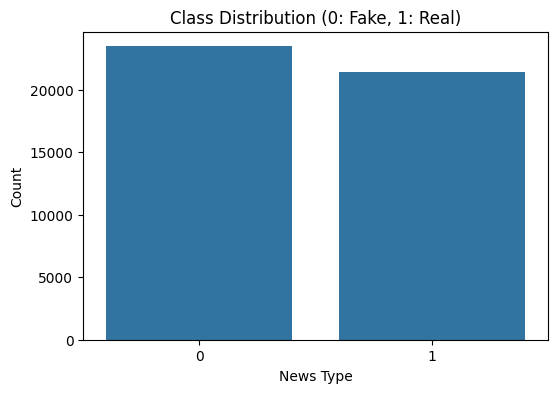

In [8]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Class Distribution (0: Fake, 1: Real)')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()


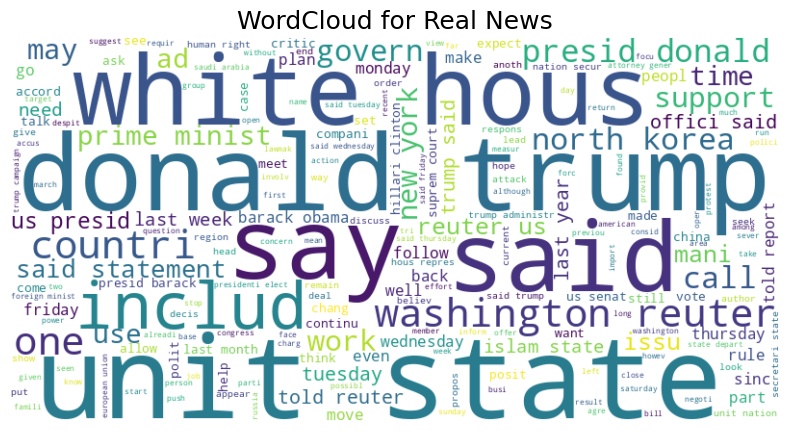

In [9]:
# WordCloud for Real News
real_text = " ".join(data[data['label'] == 1]['processed_text'])

real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10,5))
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Real News', fontsize=18)
plt.show()


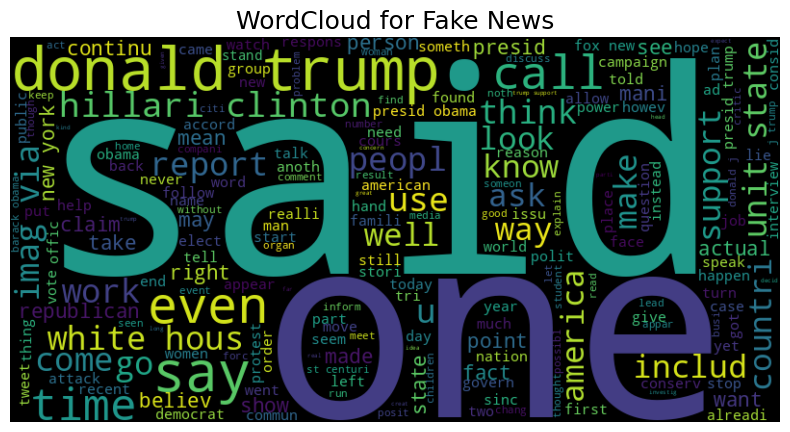

In [10]:
# WordCloud for Fake News
fake_text = " ".join(data[data['label'] == 0]['processed_text'])

fake_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Fake News', fontsize=18)
plt.show()


In [11]:
# Separate features and target
X = final_data.drop('label', axis=1)
y = final_data['label']

# 70-30 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 35918, Testing samples: 8980


In [12]:
# Define base models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
et_model = ExtraTreesClassifier(random_state=42)

# Create Bagging Ensemble with these models, update parameter to 'estimator'
bagging_models = [
    ('Decision Tree', BaggingClassifier(estimator=dt_model, n_estimators=10, random_state=42)),
    ('Random Forest', BaggingClassifier(estimator=rf_model, n_estimators=10, random_state=42)),
    ('Extra Trees', BaggingClassifier(estimator=et_model, n_estimators=10, random_state=42))
]

In [13]:
# Define hyperparameter grids
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_samples': [0.5, 0.7, 1.0],
#     'bootstrap': [True, False],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

param_grid = {
    'n_estimators': [10, 20],
    'max_samples': [0.7, 1.0],
    'bootstrap': [True],
    'max_features': [0.5, 0.7]
}


In [14]:
# For saving best models
best_models = {}

for name, model in bagging_models:
    print(f"Training and Tuning {name}...")
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                       n_iter=5, cv=2, scoring='accuracy',
                                       verbose=1, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_
    print(f"Best params for {name}: {random_search.best_params_}")
    print("="*50)


Training and Tuning Decision Tree...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best params for Decision Tree: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7, 'bootstrap': True}
Training and Tuning Random Forest...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for Random Forest: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7, 'bootstrap': True}
Training and Tuning Extra Trees...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for Extra Trees: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7, 'bootstrap': True}


Evaluating Decision Tree...
Accuracy: 85.35%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.86      4696
           1       0.88      0.81      0.84      4284

    accuracy                           0.85      8980
   macro avg       0.86      0.85      0.85      8980
weighted avg       0.85      0.85      0.85      8980



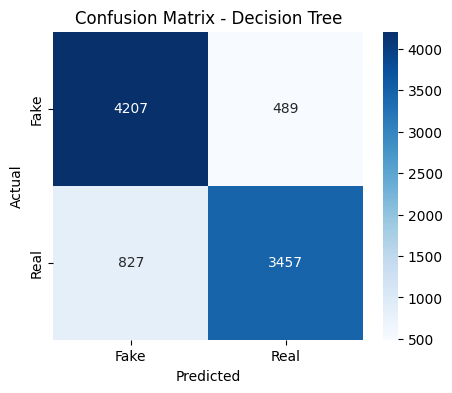

Evaluating Random Forest...
Accuracy: 86.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4696
           1       0.88      0.84      0.86      4284

    accuracy                           0.87      8980
   macro avg       0.87      0.87      0.87      8980
weighted avg       0.87      0.87      0.87      8980



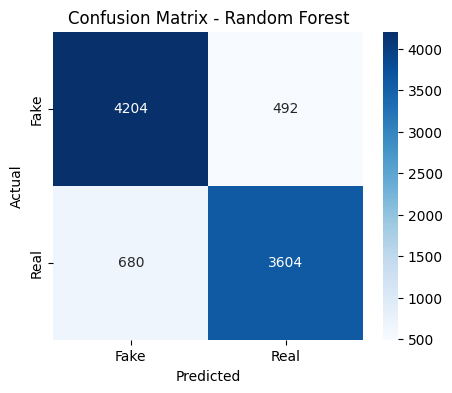

Evaluating Extra Trees...
Accuracy: 87.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4696
           1       0.88      0.86      0.87      4284

    accuracy                           0.88      8980
   macro avg       0.88      0.87      0.87      8980
weighted avg       0.88      0.88      0.88      8980



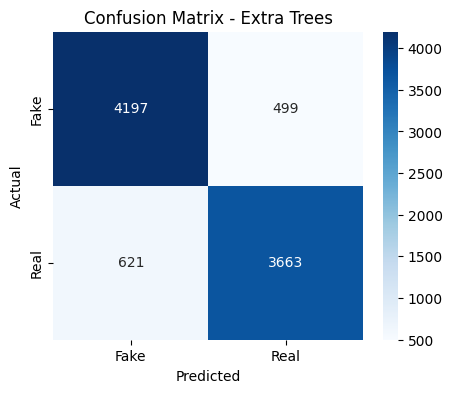

In [15]:
for name, model in best_models.items():
    print(f"Evaluating {name}...")

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print("="*60)


In [16]:
# Collect model performance
model_results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_results.append((name, acc))

# Sort results
model_results = sorted(model_results, key=lambda x: x[1], reverse=True)

# Display
print("\nModel Performance Summary:")
for name, acc in model_results:
    print(f"{name}: {acc*100:.2f}% accuracy")



Model Performance Summary:
Extra Trees: 87.53% accuracy
Random Forest: 86.95% accuracy
Decision Tree: 85.35% accuracy


In [18]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('dt', dt_model), ('rf', rf_model), ('et', et_model)], voting='hard')

# 7. Train Model
ensemble.fit(X_train, y_train)

# 8. Evaluate Model
y_pred = ensemble.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 87.75%

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      4696
           1       0.88      0.86      0.87      4284

    accuracy                           0.88      8980
   macro avg       0.88      0.88      0.88      8980
weighted avg       0.88      0.88      0.88      8980

